In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from numpy import linalg
from numba import njit
from scipy.interpolate import interp1d


On considère dans ce cas l'équation de Burgers suivante:
\begin{equation}
    \begin{cases}
    & \frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \epsilon \frac{\partial^2 u}{\partial x^2} \quad \text{pour} \quad t > 0, \quad x \in [l, L]\\
    & u(x,0)=u_0(x) \quad \forall x \in [l,L]
    \end{cases}
\end{equation}

In [65]:


#La Solution Iniciale:
@njit(cache=True)
def u0(x):
    #Chock & Détente
    if x <= 1 / 4:
        return ul
    if 1 / 4 < x < 3 / 4:
        return um
    else:
        return ur
    
@njit
def Uex(t,x):
    if T<=1/2:
        if x>=0.75 :
            if x-(3/4)<0.5*(um+ur)*t:
                return um
            else:
                return ur
        else:
            if x-(1/4)<= ul*t:
                    return ul

            elif x-(1/4)>ul*t and x-(1/4)< um*t:
                return (x-(1/4))/t
            elif x-(1/4)>=um*t:
                return um
    elif T>0.5 and T<=1:
        if x>=1.2 :
            if x-(3/4)<0.5*(um+ur)*t:
                return um
            else:
                return ur
        else:
            if x-(1/4)<= ul*t:
                    return ul

            elif x-(1/4)>ul*t and x-(1/4)< um*t:
                return (x-(1/4))/t
            elif x-(1/4)>=um*t:
                return um
    elif T>1 and T<=1.8:
        if x>=1.75 :
            if x-(3/4)<0.5*(um+ur)*t:
                return um
            else:
                return ur
        else:
            if x-(1/4)<= ul*t:
                    return ul

            elif x-(1/4)>ul*t and x-(1/4)< um*t:
                return (x-(1/4))/t
            elif x-(1/4)>=um*t:
                return um
    elif T>1.8 and T<=2:
        if x>=1.87 :
            if x-(3/4)<0.5*(um+ur)*t:
                return um
            else:
                return ur
        else:
            if x-(1/4)<= ul*t:
                    return ul

            elif x-(1/4)>ul*t and x-(1/4)< um*t:
                return (x-(1/4))/t
            elif x-(1/4)>=um*t:
                return um
    elif T>2 :
        if x>=2.3 :
            if x-(3/4)<0.5*(um+ur)*t:
                return um
            else:
                return ur
        else:
            if x-(1/4)<= ul*t:
                    return ul

            elif x-(1/4)>ul*t and x-(1/4)< um*t:
                return (x-(1/4))/t
            elif x-(1/4)>=um*t:
                return um
    

@njit(cache=True)
def u0_Gauss(x):
    # Condition initiale gaussienne
    return np.sin(np.pi * x / (L - l)) + 2.5 * (L - l) * np.sin(100 * (L - l) * np.pi * x / (L - l))




# Le flux Exacte:
@njit
def F(u):
    return (u**2)/2

# Les Flux des schemas:
@njit
def Rusanov(ug,ud,dx,dt):
    lamda= max(abs(ug),abs(ud))
    return 0.5*(F(ug)+F(ud))-lamda*(ud-ug)

@njit
def Rusanov2(ug,ud,dx,dt):
    lamda= max(abs(ug),abs(ud))
    return 0.5*(F(ug)+F(ud)-lamda*(ud-ug))

@njit
def Roe(ug,ud,dx,dt):
    return 0.5 *( (F(ug)+F(ud)) - (ug+ud)/2 *(ud-ug) )
  
@njit
def LF(ug,ud,dx,dt):
    return 0.5 *( (F(ug)+F(ud)) - (dx/dt) *(ud-ug) )

@njit
def LFM(ug,ud,dx,dt):
    return 0.5 *( (F(ug)+F(ud)) - 0.5*(dx/dt) *(ud-ug) )

@njit
def LW(ug, ud, dx, dt):
    A = 0.5 * (ud + ug)
    return 0.5 * (F(ug) + F(ud) - (dt / dx) * A * (F(ud) - F(ug)))

@njit(cache=True)
def depature_fvc_flux(dt,alpha,x,u):
    aux=1
    eps=1e-9
    x0=0.5*(x[0]+x[1])   
    x1=x0
    xmp=x0
    while(aux>eps):
        deriv=np.interp(x0, x, u)
        x1=xmp-dt*alpha*deriv
        aux=np.abs(x0-x1)
        x0=x1
    if x0>x[1]:
        x0=x[1]
    if x0<x[0]:
        x0=x[0]    
    return x0 

 
@njit(cache=True)
def fvc_flux(u,x,dt,alpha):
    
    Alpha = alpha
    x_car = depature_fvc_flux(dt, Alpha,x,  u)

    up   = np.interp(x_car, x, u)
    

    return 0.5 * up**2

@njit
def VFC(U0, T, epsilon, N,  alpha, dx, CFL,X):
    Un    = U0.copy()
    Unp1  = np.zeros(N)
    
    temps = 0
    

    
    while temps < T:
        
        if epsilon != 0 and a!=0:
            dt1  = CFL * (dx/(np.max(np.abs(Un))*np.sqrt(2*alpha)))
            dt2  = CFL * 0.5 * dx**2 / np.abs(epsilon)
            dt  = min(dt1,dt2)
        else:
            dt  = CFL * (dx/(np.max(np.abs(Un))*np.sqrt(2*alpha)))

                
        temps += min(dt,T-dt)
        
        for i in range(1,N-1):
            X1   = [X[i-1],X[i]]
            u1   = [Un[i-1],Un[i]]
            
            X2   = [X[i],X[i+1]]
            u2   = [Un[i],Un[i+1]]
            
            Fg  = fvc_flux(u1,X1,dt,alpha)
            Fd  = fvc_flux(u2,X2,dt,alpha)
            
            
            Unp1[i]=Un[i]-dt/dx*(Fd-Fg) + epsilon * (dt / (dx**2)) * (Un[i + 1] - 2 * Un[i] + Un[i - 1])
            
        Unp1[0]   = Unp1[1]
        Unp1[N-1] = Unp1[N-2]
        Un = Unp1.copy()
    return Un



@njit
def Solver ( U0, T, epsilon, N, dx, CFL, scheme ):
    if scheme == 0:
        flux = Roe 
    elif scheme == 1:
        flux = Rusanov
    elif scheme == 2:
        flux = Rusanov2
    elif scheme == 3:
        flux = LF
    elif scheme == 4:
        flux = LFM
    elif scheme == 5:
        flux = LW
    

    Un = U0.copy()
    Unp1 = np.zeros(N)
    temps = 0
    while temps < T:
        #####################################################################################################
        ## Roe ##
        if scheme == 0 :
            if epsilon != 0 :
                dt  = CFL /(max(np.abs(Un))/dx + 2 * np.abs(epsilon)/(dx**2))
            else:
                dt  = CFL *(dx / max(np.abs(Un)))
            
        ### LF  ##
        if scheme == 3:
            if epsilon != 0 :
                dt  = 0.5*CFL /(np.abs(0.5*max(Un)/dx -epsilon/(dx**2)))
            else:
                dt  = CFL *(dx / max(np.abs(Un)))

        ###  LFM ##
        if scheme == 4:
            if epsilon != 0 :
                dt  = 0.25 * CFL /(np.abs(0.5*max(Un)/dx -epsilon/(dx**2)))
            else:
                dt  = 0.5 * CFL *(dx / max(np.abs(Un)))

        ###  Rusanov ##
        if scheme == 1:
            dt  = 0.5 * CFL *(dx / max(np.abs(Un)))
        
        ###  Rusanov2 ##
        if scheme == 2:
            dt  =   CFL *(dx / max(np.abs(Un)))
                
        ###  Rusanov2 ##
        if scheme == 5:
            if epsilon !=0:
                dt1 =  CFL*dx/max(np.abs(Un))
                dt2 =  CFL * 0.5 * dx**2 / np.abs(epsilon)
                dt  =  min(dt1,dt2)  
            else: 
                dt =  CFL*dx/max(np.abs(Un))
        #####################################################################################################
        
        temps += min(dt,T-dt)
        for i in range(1,N-1):
            Fd = flux(Un[i],Un[i+1],dx,dt)
            Fg = flux(Un[i-1],Un[i],dx,dt)
            Unp1[i] = Un[i]-dt/dx*(Fd-Fg)+ epsilon * (dt / (dx**2)) * (Un[i + 1] - 2 * Un[i] + Un[i - 1])

        Unp1[0] = Unp1[1]
        Unp1[N-1] = Unp1[N-2]


        Un = Unp1.copy()
        

    return Un



###################################################################################
ul       =  0.2
um       =  0.8
ur       =  0.4
T        =  1.5
l        =  0
L        =  3
a        =  2
epsilon  =  0.001
N        =  101
CFL      =  1/2
alpha    =  1/2
X        =  np.linspace(l,L,N)
dx       =  (L-l)/(N-1)
U0       =  np.array([u0(x) for x in X])

f = {}

fluxes = {("Roe",0):1, ("Rusanov",1):1, ("Rusanov2",2):1, ("LF",3):1, ("LFM",4):1, ("LW",5):1}

for i,j in fluxes.items():  
    if j:
        f[i[0]]  =  Solver  (U0, T, epsilon, N, dx, CFL, i[1])   
    
U_VFC = VFC(U0, T, epsilon, N,  alpha, dx, CFL,X)

f["VFC"]=U_VFC


/tmp/ipykernel_11551/1712751816.py:259: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  for i in range(1,N-1):


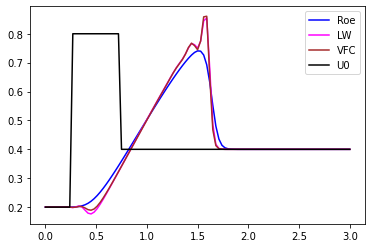

In [66]:
PLOT = {"Roe":1, "Rusanov":0, "Rusanov2":0, "LF":0, "LFM":0, "LW":1,"VFC":1 }

colors = ['blue', 'green', 'orange', 'purple', 'cyan', 'magenta', 'brown']


for i, (flux, Un) in enumerate(f.items()) :
    k = list(PLOT)[i]
    if PLOT[k]:
        plt.plot(X, Un, '-', label=flux, color=colors[i])
    
UExact = np.array([Uex(T,x) for x in X])
if epsilon !=0:
    plt.plot(X, U0, '-k',  label='U0')
else :
    plt.plot(X, UExact, '-k',  label='Uex')
        
        

#plt.xlim([0.6, 0.9])  
#plt.ylim([0.6, 0.9])  

plt.legend()
plt.pause(0.1)


In [12]:
Norm = {}
for i, (flux, Un) in enumerate(f.items()):
    Norm[flux]    =  np.linalg.norm(Un,ord = 2) 
Norm

{'Roe': 5.785429083494922,
 'Rusanov': 5.777262097600386,
 'Rusanov2': 6.068327028684875,
 'LF': 2851.0139947497087,
 'LFM': 5.7163061275824445,
 'LW': 5.805541421261755}